# Final Analysis

## 1. Problem statement (summarized)

>❓ How should Olist improve its profit margin ❓, given that it has 
> - some revenues per sellers per months
> - some revenues per orders
> - some reputation costs (estimated) per bad reviews
> - some operational costs of IT system that grows with number of orders, but not linearly (scale effects)


Our key findings so far :
- The `wait_time` was the most significant factor behind low review scores, but reading comments of the bad reviews also showed that some of them were linked to the seller or to the product itself.
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`. The latter being outside of Olist's direct control, improving it is not a quick-win recommendation we can make to Olist CEO without in-depth analysis of their operational practices.
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.

### 1.1 **Should All underperforming sellers be removed from its marketplace ?** 🕵🏻

To analyse and confirm the impact of removing the worse sellers from Olist's marketplace, we will perform a what-if analysis: What would have happened if Olist had never accepted these sellers in the first place?

1️⃣ First, we'll compute and assess, for each `seller_id`, and cumulated since the beginning:
- the `revenues` it brings
- the `costs` associated with all its bad reviews
- the resulting `profits` (revenues - costs)
- the number of `orders` (it will impact the overall IT costs)


2️⃣ Next, we will:
- sort sellers by increasing profits for Olist
- for each number of sellers to remove, compute the financial impact it would have made if they had never been accepted on the platform and find an optimal number of sellers to remove that maximizes Olist's profit margin


## Seller_id computation

### Association for the cost of bad reviews

Although we can quantify reputation of Olist by roughly aggregating overall star reviews of all seller on the platform, it is hard to attribute the impact of negative reviews with the actual profit loss of Olist. In this scenario, we've assigned a penalty cost incurred due to the negative impacts of the reviews for each order to each individual seller in order to quantify the loss due to the amount of negative reviews received.

Additional cost of the reviews on each individual seller are as follows:
- 1 star : 100 BRLs
- 2 star : 50 BRLs
- 3 star : 40 BRLs
- 4 star : 0 BRLs
- 5 star : 0 BRLs

In [1]:
from olist.seller_updated import Seller
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# get dataframe 
sellers_info = Seller().get_training_data()
sellers_info.head(3)

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70,341.870,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.0,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2290.307,2050.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.0,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00,15.800,15.800


In [3]:
#Total profits brought in by sellers
print(f'Total Profit of All Sellers to Date : {round(sellers_info["profits"].sum(),2)} BRLs')

Total Profit of All Sellers to Date : 1167608.44 BRLs


The operational IT cost is estimated to be not of a linear scale, but of $\sqrt{x}$ of the total number of orders. This is to reflect the high initial setup cost for IT and its cost down effect.

In [4]:
sell_cal = sellers_info.copy()
sell_cal['revenues']= sell_cal['sales']*0.1+80*sell_cal['months_on_olist']

# average IT cost per order can be calculated by dividing overall operation IT cost by the total amount of orders
#y = IT_g * sqrt(x)
IT_g = 500000/np.sqrt(sell_cal['n_orders']).sum()
print(f"Average Operational IT cost per order to date will be {round(IT_g,2)} BRLs")
sell_cal['IT_cost'] =  np.sqrt(sell_cal["n_orders"]) * IT_g
sell_cal['net_profit']= sell_cal['profits'] - sell_cal['IT_cost']
sell_cal.head(3)

Average Operational IT cost per order to date will be 41.98 BRLs


,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,IT_cost,net_profit
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70,341.870,201.870,72.706398,129.163602
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.0,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2290.307,2050.307,265.486228,1784.820772
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.0,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00,15.800,15.800,41.977058,-26.177058


The profit of each sellers is the deduction of its revenues with the IT cost and the additional cost incurred due to negative reviews that it receives. We'll then sort the sellers by the profit they bring to Olist and plot them out to see the trend.

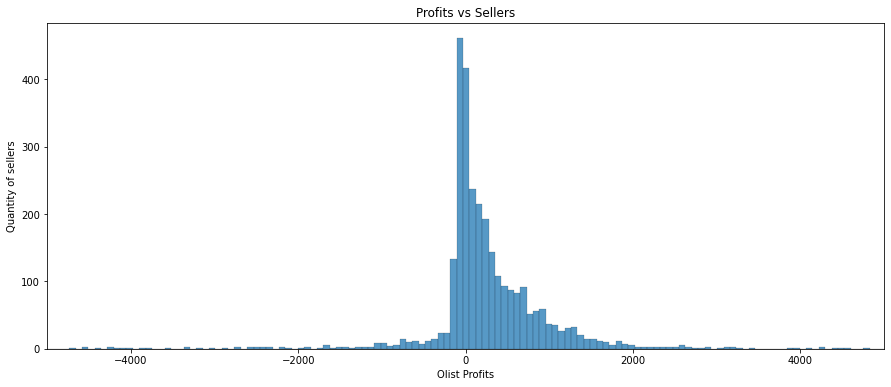

In [5]:
#Sorting sellers according to the profits 
sellers_by_profits = sell_cal.sort_values(by = "net_profit")["net_profit"].reset_index()

#Visualizing the sellers according to the sorted profits; the sellers which brings in the least profits/most losses on the left,
#and sellers with the most profits on the right
plt.figure(figsize = (15, 6))
sns.histplot(sellers_by_profits["net_profit"])
plt.title("Profits vs Sellers")
plt.xlim(-5000,5000)
plt.xlabel("Olist Profits")
plt.ylabel("Quantity of sellers");

As from both the graph above, it is shown that some sellers causes Olist to lose profit instead. We will confirm the profit difference if all the sellers that causes profit loss are removed.

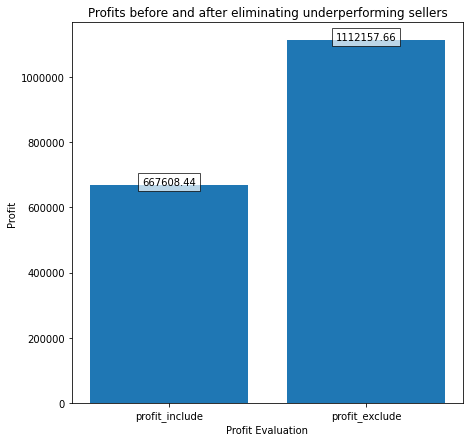

In [6]:
# Compute the overall profits before and after eliminating under-performing sellers
profit_include = sell_cal['net_profit'].sum()
profit_exclude = sell_cal[sell_cal['net_profit'] > 0]['net_profit'].sum()
values = [profit_include,profit_exclude]
profits = ['profit_include', 'profit_exclude']

# plot the chart to visualize before and after eliminating under-performing sellers. 
plt.figure(figsize=(7,7))
plt.bar(profits,values)

# Labels for bar chart
def labels(profits):
    for i in range(len(profits)):
        plt.text(i,profits[i],profits[i], ha = 'center',
                 bbox = dict(facecolor = "white", alpha =0.7))
        
plt.xlabel("Profit Evaluation")
plt.ylabel("Profit")
plt.title("Profits before and after eliminating underperforming sellers")
plt.ticklabel_format(style='plain', axis='y')
labels([np.round(x,2) for x in values])
plt.show()

In [7]:
# difference before and after removing sellers that reduces Olist profit"
print(f"Profit before removing certain sellers: {np.round(values[0],2)} BRLs")
print(f"Profit after removing certain sellers: {np.round(values[1],2)} BRLs")
print(f"Profit gained from removing sellers that reduces profit will be \
around {np.round(values[1]-values[0],2)} BRLs (increases by {np.round((values[1]-values[0])/values[0],2)*100}%)")

Profit before removing certain sellers: 667608.44 BRLs
Profit after removing certain sellers: 1112157.66 BRLs
Profit gained from removing sellers that reduces profit will be around 444549.21 BRLs (increases by 67.0%)


The calculation above shows the maximum amount of profit gained due to the removal of certain sellers. Next we will visualize the change in profits when removing more and more sellers to confirm that our answer is the optimum quantity.

In [8]:
#Sorting sellers in the dataframe by the profits that they bring to the company
sorted_sellers = sell_cal.sort_values(by = "net_profit")

#Calculating the cumulated profits achieved after removing each seller (from the sellers with least profit/most losses, to the
#sellers with the most profits), and appending them to a list for visualisation purpose later
profit = []

for i in range(len(sorted_sellers)):
    
    tmp = sorted_sellers[i:]
    it_costs = (tmp["n_orders"])**0.5 * IT_g
    total_profits = (tmp["profits"] - it_costs).sum()
    profit.append(total_profits)

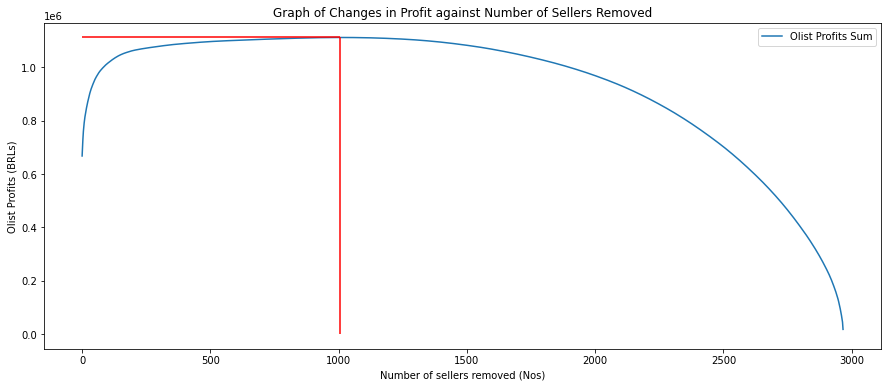

In [9]:
#Visualising the cumulative profits achieved after removing each seller, starting from the sellers with least profit/most losses,
#to the sellers with the most profits
x = [i for i in range(len(sorted_sellers))]
plt.figure(figsize = (15,6))
plt.plot(x, profit, label="Olist Profits Sum")
plt.ylabel("Olist Profits (BRLs)")
plt.xlabel("Number of sellers removed (Nos)")
plt.vlines(profit.index(max(profit)),0,max(profit), colors="r")
plt.hlines(max(profit),0,profit.index(max(profit)), colors="r")
plt.legend()
plt.title("Graph of Changes in Profit against Number of Sellers Removed");

## Further analysis into the sellers that reduces Olist profits

Although direct removal of sellers that reduces Olist profits will have the most direct result, there are certain aspects that we need to confirm if this is the most ideal condition. One aspects that we didn't confirm is to check if the sellers that are in the removal lists are newcomers to the Olist platform. If the sellers affected is a newcomer, is it possible if we give an observation period for them to adjust and improve before removing them from the platform?

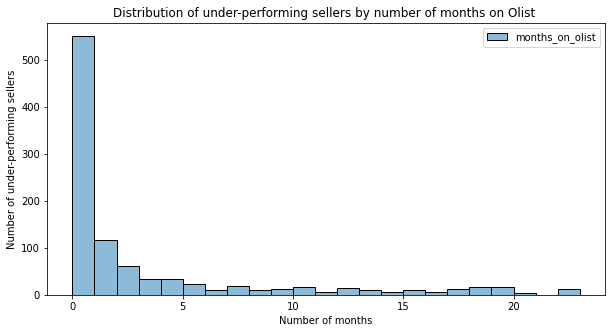

Total number of sellers to be removed is 1004


In [10]:
# Plotting the distribution of under-performing sellers by the number of months on Olist
plt.figure(figsize=(10,5))
sns.histplot(sell_cal[(sell_cal['net_profit'] < 0)][['months_on_olist']],binwidth=1)
num_underperforming_sellers = sell_cal[(sell_cal['net_profit'] < 0)]['months_on_olist'].count()

plt.xlabel("Number of months")
plt.ylabel("Number of under-performing sellers")
plt.title("Distribution of under-performing sellers by number of months on Olist ")
plt.show()
print(f"Total number of sellers to be removed is {profit.index(max(profit))}")

As per histogram above, it is clearly shown that more than 50% of the sellers are only onto Olist for less than 1 month. Remaining sellers are onto Olist platform from 2 months up until 23 months. To see clearly the distribution, the data will be tabulated with also the cumulative percentage for clear visualisation.

In [11]:
# The distribution of underperforming sellers are tabulated as shown below. Cumulative percentage of the sellers 
agg = sell_cal[(sell_cal['net_profit'] < 0)].groupby("months_on_olist").agg({'seller_id':'count','profits':'sum','net_profit':'sum'})
agg.rename(columns={'seller_id':'Number of Sellers'}, inplace=True)
agg['cum_percent'] = 100*(agg['Number of Sellers'].cumsum() / agg['Number of Sellers'].sum())
agg

,Number of Sellers,profits,net_profit,cum_percent
months_on_olist,,,,
0.0,551,-5002.346,-31237.748509,54.880478
1.0,116,-565.709,-11519.097072,66.434263
2.0,61,229.661,-6858.051316,72.509960
3.0,33,-1900.112,-8148.538759,75.796813
4.0,34,-2570.929,-10293.116758,79.183267
5.0,23,-5853.651,-11871.475621,81.474104
6.0,11,-2945.188,-5944.711385,82.569721
7.0,19,-15711.716,-22928.604539,84.462151
8.0,10,-1297.004,-4998.223474,85.458167


In [91]:
print(f"Percentage of underperforming sellers loss that are less than 5 months: \
{np.round(agg.loc[0:5,'net_profit'].sum()/agg.sum()[2]*100,2)} % ")
print(f"Percentage of underperforming sellers loss that are less than 1 months: \
{np.round(agg.loc[0,'net_profit'].sum()/agg.sum()[2]*100,2)} % ")

Percentage of underperforming sellers loss that are less than 5 months: 17.98 % 
Percentage of underperforming sellers loss that are less than 1 months: 7.03 % 


From the table above, we can see that 54.9% of sellers are on Olist platform in less than 1 month and they account for 7% of overall loss, and 81.5% of sellers that are 5 months or less on Olist platform accounts for 18% of overall loss.  
We then confirm if the profit earned by Olist is greatly affected if we do not remove those underperforming sellers that are 5 months or less on Olist.

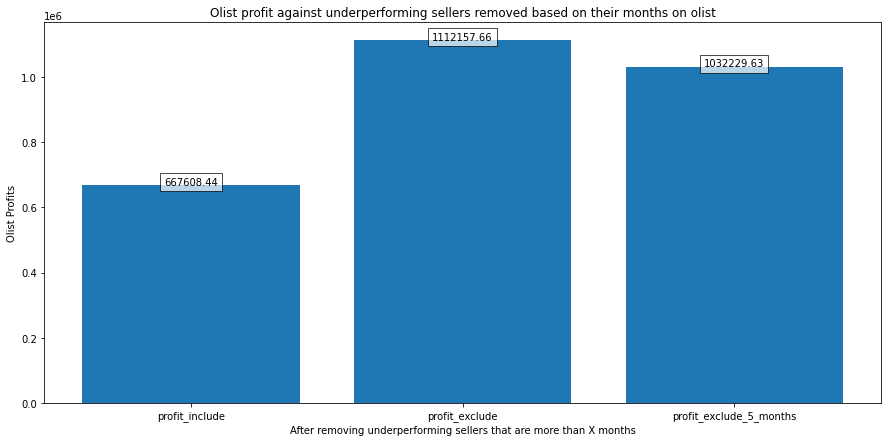

In [13]:
profit_exclude_5mth = sell_cal[~((sell_cal['net_profit'] < 0)&(sell_cal['months_on_olist']>=6))]['net_profit'].sum()

# Compute the overall profits before and after eliminating under-performing sellers
profit_include = sell_cal['net_profit'].sum()
profit_exclude = sell_cal[sell_cal['net_profit'] > 0]['net_profit'].sum()
values = [profit_include,profit_exclude, profit_exclude_5mth]
profits = ['profit_include', 'profit_exclude','profit_exclude_5_months']

# plot the chart to visualize before and after eliminating under-performing sellers. 
plt.figure(figsize=(15,7))
plt.bar(profits,values)

# Labels for bar chart
def labels(profits):
    for i in range(len(profits)):
        plt.text(i,profits[i],profits[i], ha = 'center',
                 bbox = dict(facecolor = "white", alpha =0.7))

plt.title('Olist profit against underperforming sellers removed based on their months on olist')
plt.xlabel("After removing underperforming sellers that are more than X months")
plt.ylabel("Olist Profits")
labels([np.round(x,2) for x in values])
plt.show()

In [14]:
print(f"Profit earned after excluding sellers that are more than 5 months in Olist is \
{np.round(profit_exclude_5mth-profit_include,2)} BRLs ({np.round((profit_exclude_5mth-profit_include)/profit_include*100,2)} \
% increase)")

Profit earned after excluding sellers that are more than 5 months in Olist is 364621.19 BRLs (54.62 % increase)


We could see that when we give the sellers that are 5 months or less on Olist a probation period (which is 80% of the underperforming sellers), Olist profit is still able to increase by 54.62%.  
Furthermore, new sellers will need some extra time and sales to build their business on the Olist platform. The method of removing new sellers as soon as they are underperforming upon arrival will be bad for the platform's health. This will discourage new SME sellers to board the Olist platform.

We'll double check the percentage of new sellers ( 5 months or less ) that is under-performing to see if it is a prevalent trend within new sellers.

In [15]:
underperform_new_sellers = sell_cal[((sell_cal['net_profit'] < 0)&(sell_cal['months_on_olist']<6))]['net_profit']
perform_new_sellers = sell_cal[((sell_cal['net_profit'] > 0)&(sell_cal['months_on_olist']<6))]['net_profit']
percentage = underperform_new_sellers.shape[0]/(underperform_new_sellers.shape[0]+perform_new_sellers.shape[0])*100
print(f"Number of under-performing new sellers : {underperform_new_sellers.shape[0]}")
print(f"Number of performing new sellers : {perform_new_sellers.shape[0]}")
print(f"Percentage of under-performing new sellers among all new sellers : {round(percentage,2)} %")

Number of under-performing new sellers : 818
Number of performing new sellers : 911
Percentage of under-performing new sellers among all new sellers : 47.31 %


As we can see, almost 50% of new sellers is under-performing among all of Olist new sellers, Olist can discuss further to see if can set the first few months as monitoring period and provide some form of guide which could able to shorten the time needed for the new sellers to gain traction on the platform

In [83]:
underperform_sellers = sell_cal[((sell_cal['net_profit'] < 0)&(sell_cal['months_on_olist']>=6))]
underperform_sellers2 = sell_cal[((sell_cal['net_profit'] < 0)&(sell_cal['months_on_olist']>=12))]

In [96]:
perform_sellers = sell_cal[((sell_cal['net_profit'] > 0)&(sell_cal['months_on_olist']>=6))]
print(f" Num of performing sellers : {perform_sellers.shape[0]}")
print(f" Num of underperforming sellers >6 months: {underperform_sellers.shape[0]}") 
print(f" Num of underperforming sellers >12 months: {underperform_sellers2.shape[0]}") 
print(f" % of underperform sellers >6 months: {round(underperform_sellers.shape[0]/perform_sellers.shape[0]*100,2)} %")
print(f" % of underperform sellers >12 months: {round(underperform_sellers2.shape[0]/perform_sellers.shape[0]*100,2)} %")

 Num of performing sellers : 1052
 Num of underperforming sellers >6 months: 186
 Num of underperforming sellers >12 months: 110
 % of underperform sellers >6 months: 17.68 %
 % of underperform sellers >12 months: 10.46 %


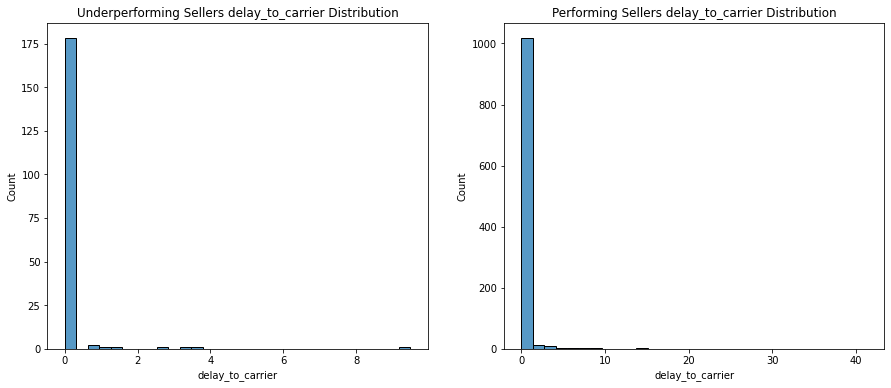

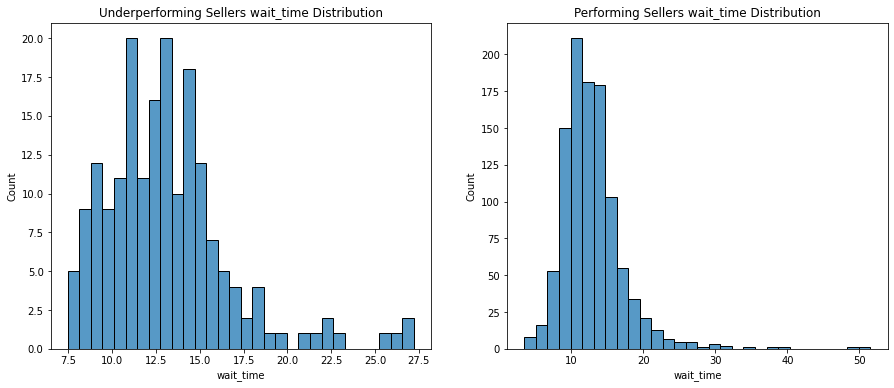

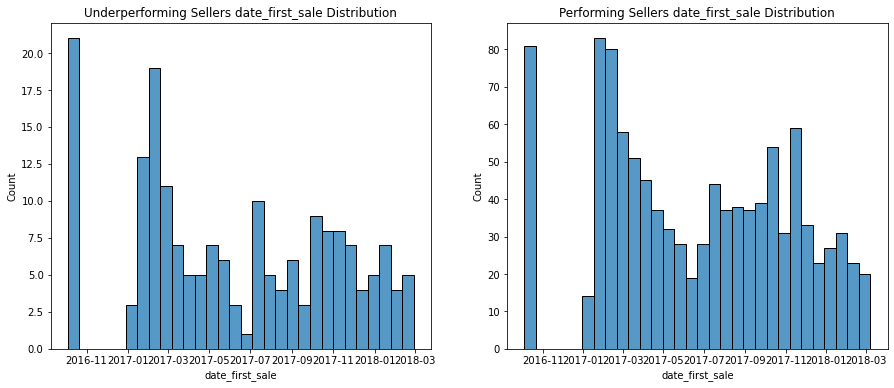

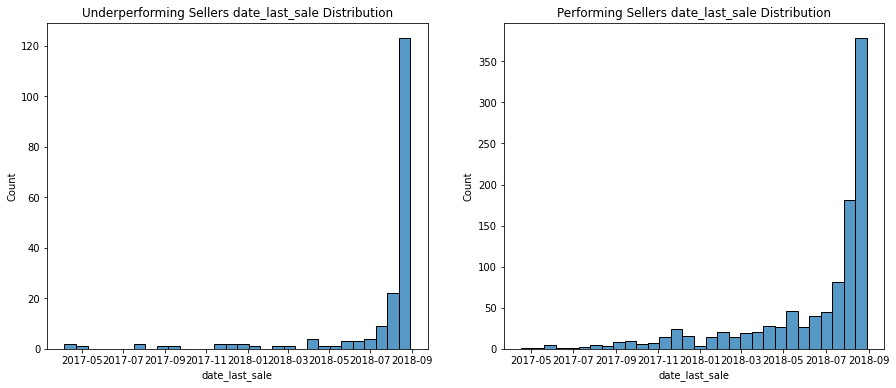

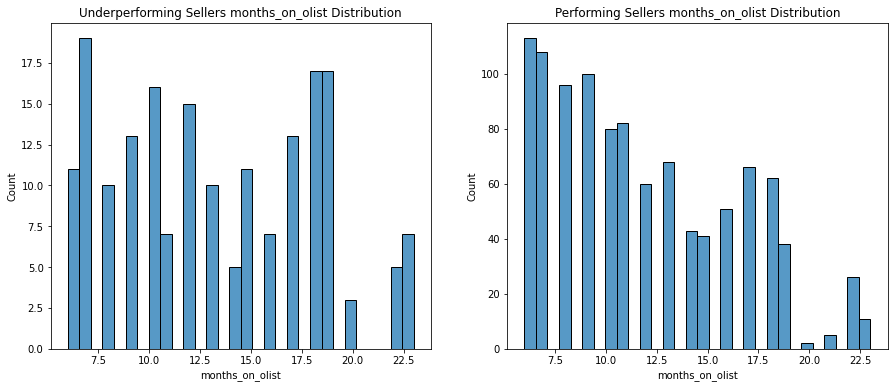

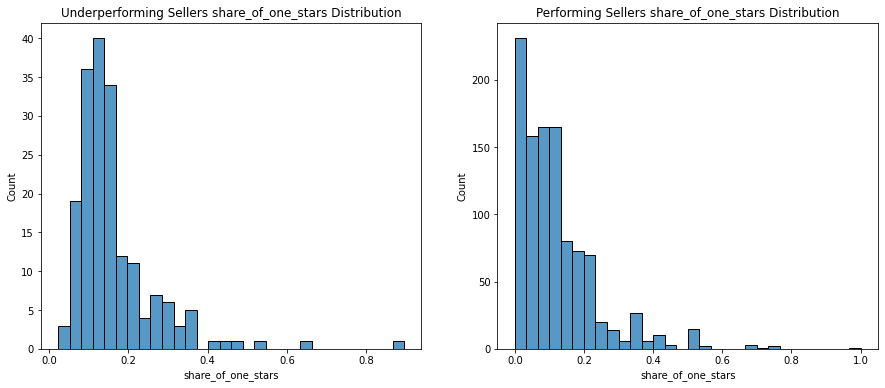

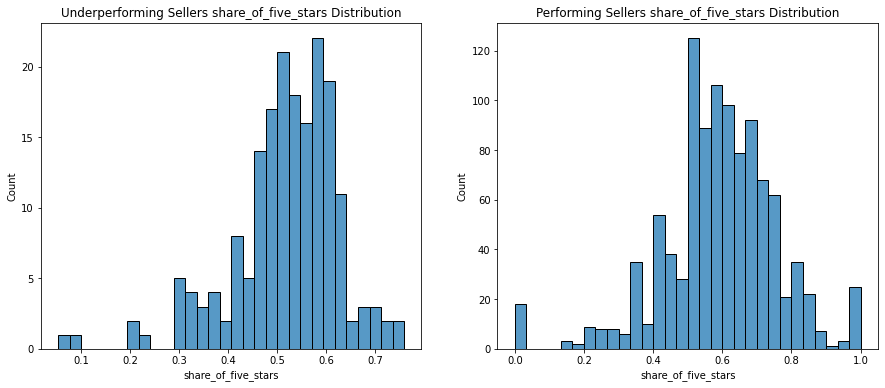

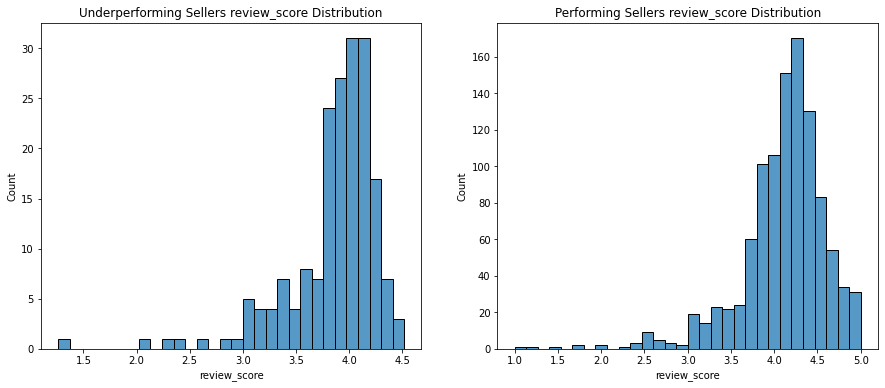

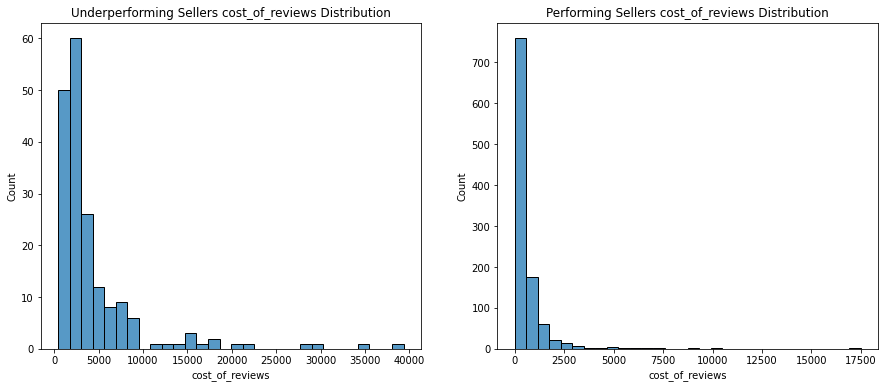

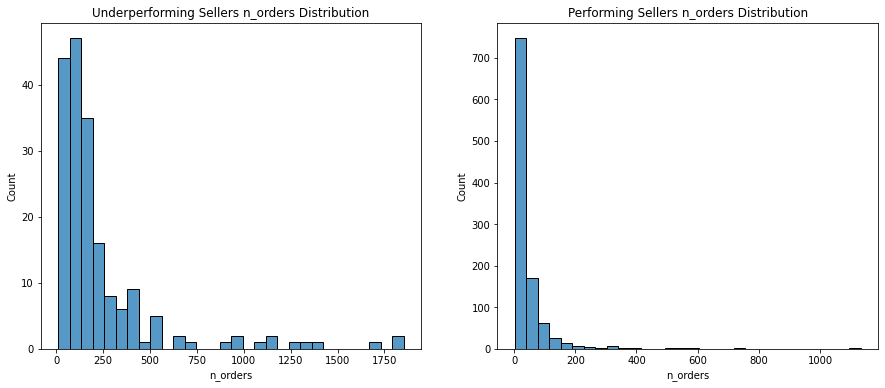

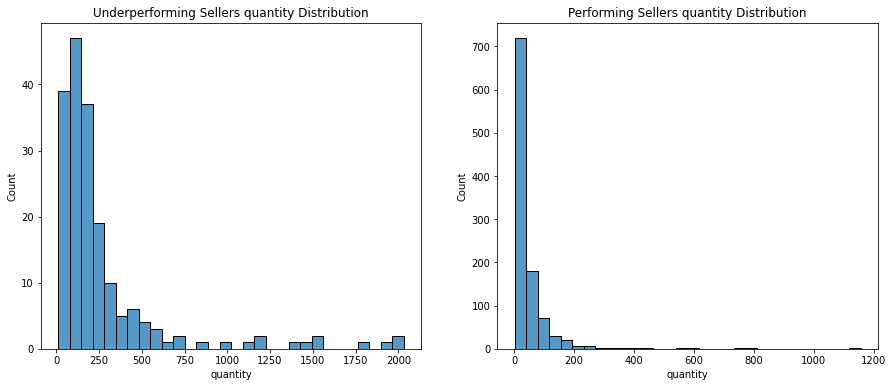

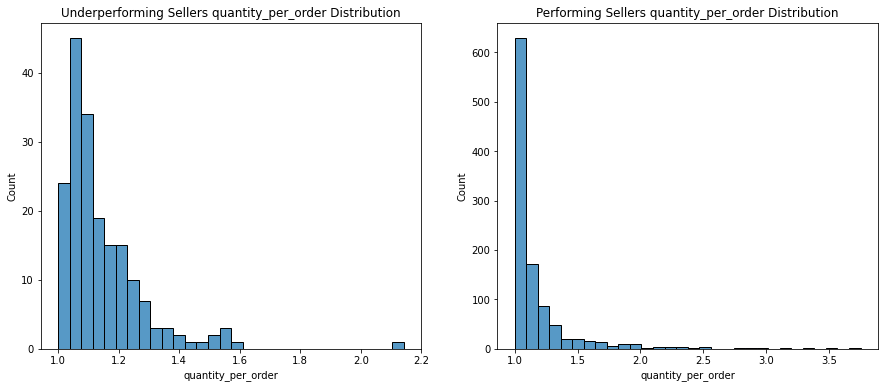

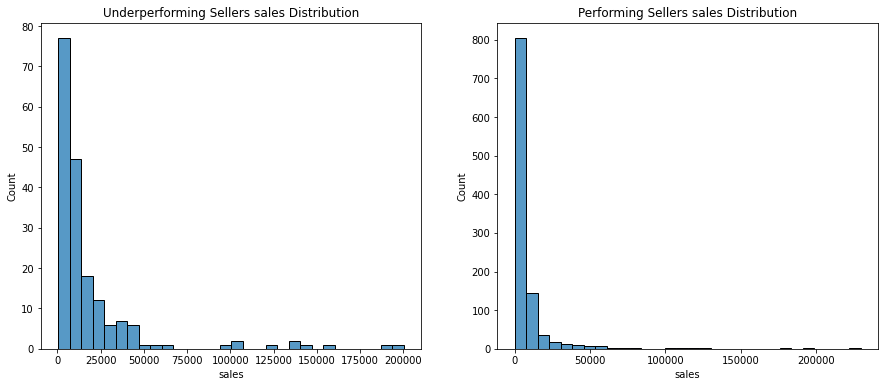

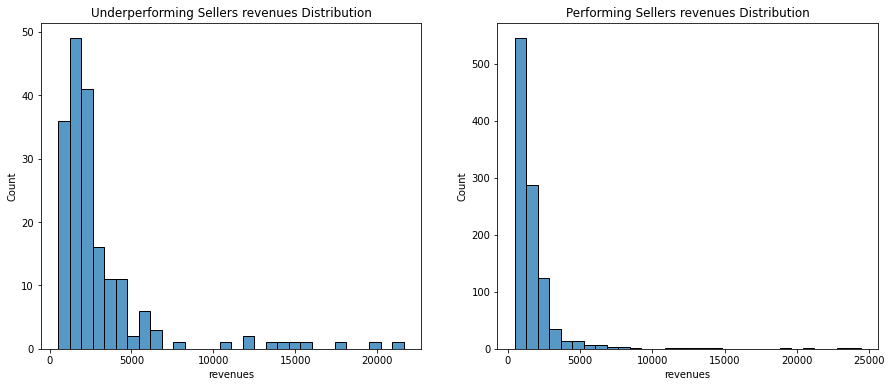

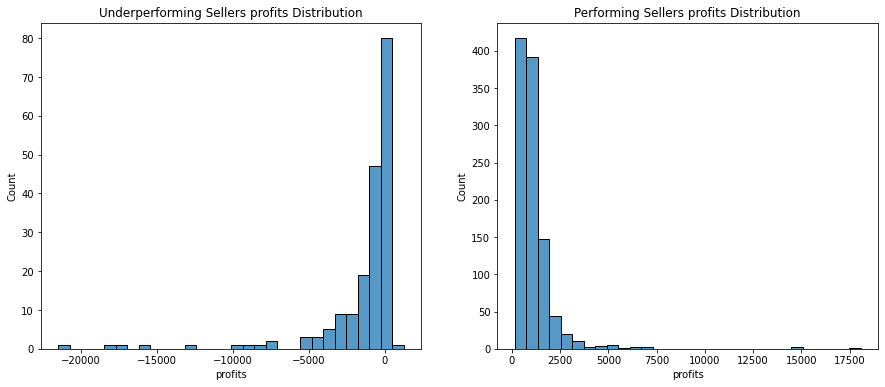

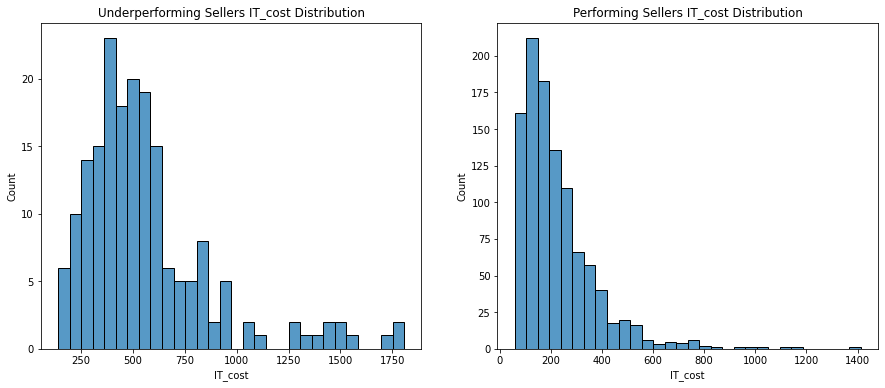

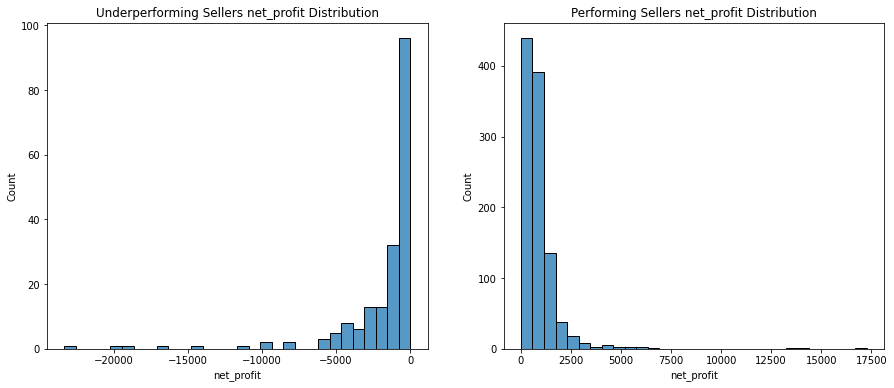

In [73]:
graph_list = perform_sellers.columns[3:]

for index,a in enumerate(graph_list):
    fig, ax = plt.subplots(1,2, figsize=(15,6))
    sns.histplot(underperform_sellers[a],bins=30, ax=ax[0]).set(title=f"Underperforming Sellers {a} Distribution");
    sns.histplot(perform_sellers[a],bins=30, ax=ax[1]).set(title=f"Performing Sellers {a} Distribution");

We compared the distribution between underperforming and performing sellers to see if there's any distinct pattern that can be identified. Other than the obvious difference between profit and net_profit which was previously filtered for investigation, both data shows similar trend between all the features. This means that the checked features are not the distinct reason causing the difference between the data.

## Suggestion & Recommendation

### Suggestion : Removing Underperforming Sellers

1. By removing under-performing sellers that are more than 5 months in Olist, your profit is estimated to be able to increase by 54.62%. 
2. For the under-performing sellers that are less than 5 months, they account for only 18% of the total loss. We also found out that 47% of the new sellers are under-performing within the first 5 months. The percentage of under-performing sellers dropped to 17.68% after 6 months and finally to 10.46% after 1 year.
3. The percentage drop above suggests Olist can consider to provide some form of guidance to the new incoming under-performing sellers such as additional training or consultation that may help the new sellers to gain traction at Olist platform faster.

### Recommendation : Further Analysis of Low Review Category

Further analyze the reviews using statistical techniques such as Natural Language Processing to determine why customers give bad and good reviews. The categorization of the bad reviews will help to identify what is the critical factor that will affect negative reviews for further identification and troubleshooting. 